# Two Layer Model
This notebook implements a two-layer regression model:
- Layer 1: Random Forest regression to predict ESG Pillar scores and Disclosure scores
- Layer 2: Linear Regression to predict ESG Score

In [1]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('..'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import numpy as np
from transformer.data_preprocessing import prepare_data_for_modeling
from TwoLayerModel import TwoLayerModel, plot_actual_vs_predicted_two_layer, plot_feature_importances

### 1. Data preparation 

In [2]:
# Define the pillar and disclosure columns that will be used as intermediate targets
pillar_disclosure_columns = [
    'BESG Environmental Pillar Score',
    'BESG Social Pillar Score',
    'BESG Governance Pillar Score',
    'ESG Disclosure Score',
    'Environmental Disclosure Score',
    'Social Disclosure Score',
    'Governance Disclosure Score'
]

# Final target column
final_target = 'BESG ESG Score'

In [3]:
# Define the relative path to the CSV file
file_path = os.path.join('..', 'Data', 'energy_cleaned.csv')

# Load the data
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Raw Materials Used,Percentage Gender Pay Gap Employees Ex Management,Percentage Raw Material from Sustainable Sources,"Revenue, Adj","Net Income, Adj",Margin %,"EPS, Adj",Market Cap ($M),Market Cap Category,Country
0,ACS Actividades de Construccion y Servicios SA,ACS,2014,NaN,NaN,NaN,NaN,50.729,37.511,33.676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap,Spain
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.850,0.660,2.380,3.660,55.296,42.616,41.717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap,Spain
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.170,1.130,2.370,4.050,55.497,48.354,36.578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap,Spain
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.760,1.130,4.300,4.110,57.248,50.317,44.891,...,"5,140.650",NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap,Spain
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.630,1.110,4.200,3.640,62.609,52.280,59.039,...,"8,653.300",NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap,Spain


In [4]:
# Remove rows with missing BESG ESG Score
df = df.dropna(subset=['BESG ESG Score'])
df['BESG ESG Score'].isna().sum()

# Drop columns with more than 70% missing values
df = df.dropna(thresh=0.7*len(df), axis=1)

# Drop Market Cap column
df = df.drop(columns=['Market Cap ($M)'])

# Drop rows with '#N/A Requesting Data...'
df = df[~df['BESG ESG Score'].str.contains('#N/A Requesting Data...')]

df.shape

(850, 67)

In [5]:
numeric_cols = [
    'BESG ESG Score', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score',
    'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score',
    'Social Disclosure Score', 'Governance Disclosure Score', 'Nitrogen Oxide Emissions',
    'VOC Emissions', 'Particulate Emissions', 'Sulphur Dioxide / Sulphur Oxide Emissions',
    'GHG Scope 1', 'GHG Scope 2 Location-Based', 'GHG Scope 3', 'Carbon per Unit of Production',
    'Fuel Used - Natural Gas', 'Energy Per Unit of Production', 'Community Spending',
    'Pct Women in Middle and or Other Management', 'Pct Women in Workforce',
    'Fatalities - Employees', 'Fatalities - Contractors', 'Fatalities - Total',
    'Lost Time Incident Rate - Employees', 'Lost Time Incident Rate - Contractors',
    'Lost Time Incident Rate - Workforce', 'Total Recordable Incident Rate - Employees',
    'Total Recordable Incident Rate - Contractors', 'Total Recordable Incident Rate - Workforce',
    'Number of Employees - CSR', 'Number of Contractors', 'Employee Turnover Pct',
    'Years Auditor Employed', 'Size of Audit Committee',
    'Number of Independent Directors on Audit Committee', 'Audit Committee Meetings',
    'Audit Committee Meeting Attendance Percentage', 'Board Size',
    'Number of Executives / Company Managers', 'Number of Non Executive Directors on Board',
    'Number of Board Meetings for the Year', 'Board Meeting Attendance Pct',
    'Size of Compensation Committee', 'Num of Independent Directors on Compensation Cmte',
    'Number of Compensation Committee Meetings', 'Compensation Committee Meeting Attendance %',
    'Number of Female Executives', 'Number of Women on Board',
    'Age of the Youngest Director', 'Age of the Oldest Director',
    'Number of Independent Directors', 'Size of Nomination Committee',
    'Num of Independent Directors on Nomination Cmte', 'Number of Nomination Committee Meetings',
    'Nomination Committee Meeting Attendance Percentage', 'Board Duration (Years)',
    'Carbon Monoxide Emissions', 'CO2 Scope 1', 'Total Energy Consumption',
    'Electricity Used', 'Total Waste', 'Waste Recycled', 'Waste Sent to Landfills',
    'Total Water Withdrawal', 'Total Water Discharged', 'Water Consumption',
    'Pct Women in Senior Management', 'Pct Minorities in Workforce',
    'Pct Employees Unionized', 'Employee Training Cost',
    'Total Hours Spent by Firm - Employee Training', 'Fuel Used - Coal/Lignite',
    'Fuel Used - Crude Oil/Diesel', 'Hazardous Waste',
    'Pct Minorities in Management', 'Pct Disabled in Workforce',
    'CO2 Scope 2 Location-Based', 'Water per Unit of Production', 'Pct Recycled Materials',
    'Number of Suppliers Audited', 'Percentage Suppliers Audited',
    'Number of Supplier Audits Conducted', 'Number Supplier Facilities Audited',
    'Percentage of Suppliers in Non-Compliance', 'Number of Customer Complaints',
    'Raw Materials Used', 'Revenue, Adj', 'Net Income, Adj'
]

for col in df.columns:
    if col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

binary_cols = [
    'Risks of Climate Change Discussed', 'Policy Against Child Labor',
    'Gender Pay Gap Breakout', 'Human Rights Policy', 'Equal Opportunity Policy',
    'Business Ethics Policy', 'Anti-Bribery Ethics Policy', 'Health and Safety Policy',
    'Training Policy', 'Social Supply Chain Management', 'Emissions Reduction Initiatives',
    'Climate Change Policy', 'Climate Change Opportunities Discussed',
    'Energy Efficiency Policy', 'Waste Reduction Policy',
    'Environmental Supply Chain Management', 'Water Policy', 'Biodiversity Policy',
    'Quality Assurance and Recall Policy', 'Consumer Data Protection Policy',
    'Fair Remuneration Policy', 'Employee CSR Training', 'Renewable Energy Use',
    'Company Conducts Board Evaluations', 'Company Has Executive Share Ownership Guidelines',
    'Director Share Ownership Guidelines', 'Transition Plan Claim',
    'Adopts TNFD Recommendations', 'Zero Deforestation Policy',
    'Board Level Oversight of Biodiversity', 'Executive Level Oversight of Biodiversity',
    'Company Discloses Employee Engagement Score', 'Verification Type'
]

# Impute missing values for numeric columns
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mean())

# Impute missing values for binary columns
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0}).astype('bool')
        df[col] = df[col].fillna(df[col].mode()[0])

# Impute missing values for categorical columns
for col in df.columns:
    if df[col].dtype == 'object' and col not in ['Company', 'Ticker']:
        df[col] = df[col].fillna(df[col].mode()[0])
        df[col] = df[col].astype('category')

# Check if there are any missing values
df.isnull().sum()

Company                            0
Ticker                             0
Year                               0
BESG ESG Score                     0
BESG Environmental Pillar Score    0
                                  ..
Fair Remuneration Policy           0
Verification Type                  0
Employee CSR Training              0
Market Cap Category                0
Country                            0
Length: 67, dtype: int64

In [6]:
# One-hot encode categorical columns without Company and Ticker
df = pd.get_dummies(df, columns=df.select_dtypes(include='category').columns)

df.head()

,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Country_New Zealand,Country_Norway,Country_Poland,Country_Portugal,Country_Spain,Country_Switzerland,Country_Thailand,Country_United Arab Emirates,Country_United Kingdom,Country_United States
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.85,0.66,2.38,3.66,55.296,42.616,41.717,...,False,False,False,False,True,False,False,False,False,False
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.17,1.13,2.37,4.05,55.497,48.354,36.578,...,False,False,False,False,True,False,False,False,False,False
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.76,1.13,4.30,4.11,57.248,50.317,44.891,...,False,False,False,False,True,False,False,False,False,False
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.63,1.11,4.20,3.64,62.609,52.280,59.039,...,False,False,False,False,True,False,False,False,False,False
5,ACS Actividades de Construccion y Servicios SA,ACS,2019,2.79,1.31,4.21,3.87,64.390,57.626,59.039,...,False,False,False,False,True,False,False,False,False,False


In [7]:
# Columns to drop from features
cols_to_drop = [
    'BESG ESG Score',
    'BESG Environmental Pillar Score',
    'BESG Social Pillar Score',
    'BESG Governance Pillar Score',
    'ESG Disclosure Score',
    'Environmental Disclosure Score',
    'Social Disclosure Score',
    'Governance Disclosure Score',
    'Company',
    'Ticker'
]

In [8]:
# Drop rows with missing ESG scores
df, cat_features, num_features = prepare_data_for_modeling(df)

print(f"Number of categorical features: {len(cat_features)}")
print(f"Number of numerical features: {len(num_features)}")

# Show sample of features
print("\nSample categorical features:", cat_features[:5])
print("Sample numerical features:", num_features[:5])

# Split the data into training, validation, and test sets
X = df[cat_features + num_features]

# Verify columns to drop are in the DataFrame
print(f"Columns before dropping: {X.columns.tolist()}")

# Drop the specified columns
cols_to_drop = ['BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score', 'Social Disclosure Score', 'Governance Disclosure Score', 'Company', 'Ticker']
X = X.drop(columns=cols_to_drop)

# Verify columns after dropping
print(f"Columns after dropping: {X.columns.tolist()}")

# Update cat_features and num_features to exclude dropped columns
cat_features = [col for col in cat_features if col not in cols_to_drop]
num_features = [col for col in num_features if col not in cols_to_drop]

y = df[['BESG ESG Score', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score', 'Social Disclosure Score', 'Governance Disclosure Score']]

# First split: train+val vs test (80% vs 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: train vs val (80% vs 20% of train_val, which is 64% vs 16% of the original data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Identified 3 categorical features
Identified 41 numerical features
Number of categorical features: 3
Number of numerical features: 41

Sample categorical features: ['Company', 'Ticker', 'Year']
Sample numerical features: ['BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score']
Columns before dropping: ['Company', 'Ticker', 'Year', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score', 'Social Disclosure Score', 'Governance Disclosure Score', 'Nitrogen Oxide Emissions', 'GHG Scope 1', 'GHG Scope 2 Location-Based', 'Pct Women in Workforce', 'Fatalities - Employees', 'Fatalities - Total', 'Total Recordable Incident Rate - Employees', 'Number of Employees - CSR', 'Years Auditor Employed', 'Size of Audit Committee', 'Number of Independent Directors on Audit Committee', 'Audit Committee Meetings', 'A

### 2.  Train two-layer model for comparison


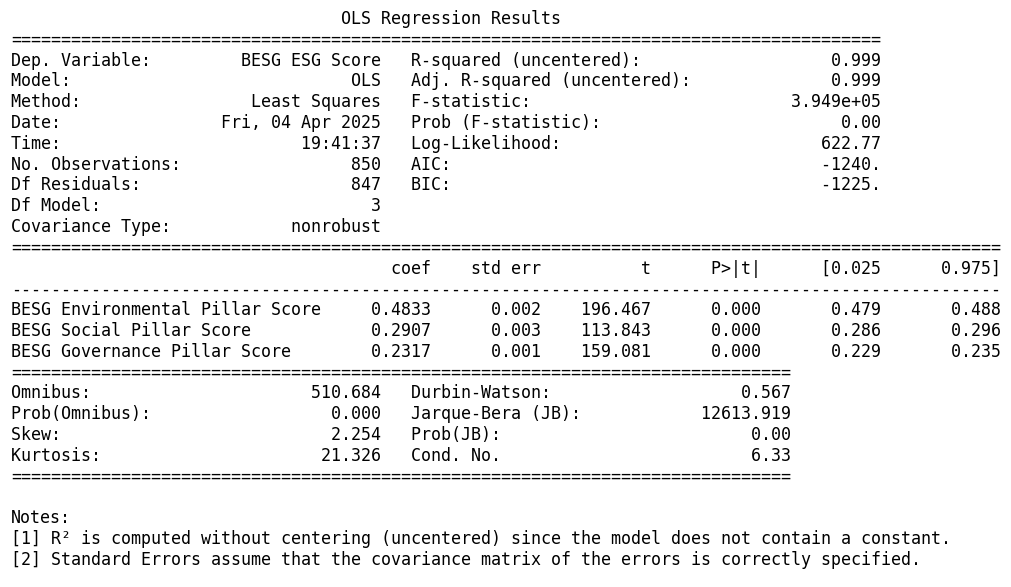

In [9]:
pillar_disclosure_columns = [
    'BESG Environmental Pillar Score',
    'BESG Social Pillar Score',
    'BESG Governance Pillar Score',
]

layer2_model = sm.OLS(y['BESG ESG Score'], y[pillar_disclosure_columns]).fit()

fig, ax = plt.subplots()
summary_text = str(layer2_model.summary())
ax.text(0.01, 0.05, summary_text, fontfamily='monospace', fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Get the coefficients from the OLS model
layer2_coefficients = layer2_model.params

# Create the TwoLayerModel with the coefficients only
two_layer_model = TwoLayerModel(
    cat_features=cat_features,
    num_features=num_features
    #layer2_coefficients=layer2_coefficients  # Pass only the coefficients
)

# Fit and evaluate the model
two_layer_model.fit(X_train, y_train)
two_layer_metrics = two_layer_model.evaluate(X_val, y_val)
print(two_layer_metrics)

Training model for BESG Environmental Pillar Score...
Top 5 features for BESG Environmental Pillar Score:
                                            Feature  Importance
0                     num__Nitrogen Oxide Emissions    0.210887
13                                  num__Board Size    0.087513
2                   num__GHG Scope 2 Location-Based    0.071507
6   num__Total Recordable Incident Rate - Employees    0.058985
23                    num__Number of Women on Board    0.057473
Training model for BESG Social Pillar Score...
Top 5 features for BESG Social Pillar Score:
                                            Feature  Importance
6   num__Total Recordable Incident Rate - Employees    0.165065
4                       num__Fatalities - Employees    0.085881
15  num__Number of Non Executive Directors on Board    0.073202
3                       num__Pct Women in Workforce    0.046484
2                   num__GHG Scope 2 Location-Based    0.041927
Training model for BESG Governance

In [11]:
X_combined = pd.concat([X_train, X_val, X_test], axis=0)
y_combined = pd.concat([y_train, y_val, y_test], axis=0)

two_layer_metrics = two_layer_model.evaluate(X_combined, y_combined)
print("Metrics for full dataset:")
print(two_layer_metrics)

Metrics for full dataset:
                            Target    Layer       MSE      RMSE       MAE  \
0  BESG Environmental Pillar Score  Layer 1  0.575218  0.758431  0.511871   
1         BESG Social Pillar Score  Layer 1  0.460222  0.678397  0.483036   
2     BESG Governance Pillar Score  Layer 1  0.187434  0.432936  0.280517   
3                   BESG ESG Score  Layer 2  0.231242  0.480877  0.324057   

   R² Score  Adjusted R² Score  
0  0.848772           0.848593  
1  0.852058           0.851883  
2  0.905285           0.905173  
3  0.884673           0.884264  


In [12]:
# Save the model
import joblib
model_path = os.path.join('..', 'TwoLayerModel', 'two_layer_model.pkl')
joblib.dump(two_layer_model, model_path)
print(f"Model saved to {model_path}")

# Load the model (for usage in production)
loaded_model = joblib.load(model_path)
# Evaluate the loaded model
loaded_model_metrics = loaded_model.evaluate(X_test, y_test)
print("\n Loaded Model Performance:")
print(loaded_model_metrics)

Model saved to ../TwoLayerModel/two_layer_model.pkl

 Loaded Model Performance:
                            Target    Layer       MSE      RMSE       MAE  \
0  BESG Environmental Pillar Score  Layer 1  1.327266  1.152070  0.877675   
1         BESG Social Pillar Score  Layer 1  0.988806  0.994387  0.754719   
2     BESG Governance Pillar Score  Layer 1  0.430290  0.655965  0.459834   
3                   BESG ESG Score  Layer 2  0.566501  0.752662  0.568383   

   R² Score  Adjusted R² Score  
0  0.692894           0.691066  
1  0.695469           0.693657  
2  0.760540           0.759115  
3  0.750829           0.746326  


/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_32496/4210039086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')


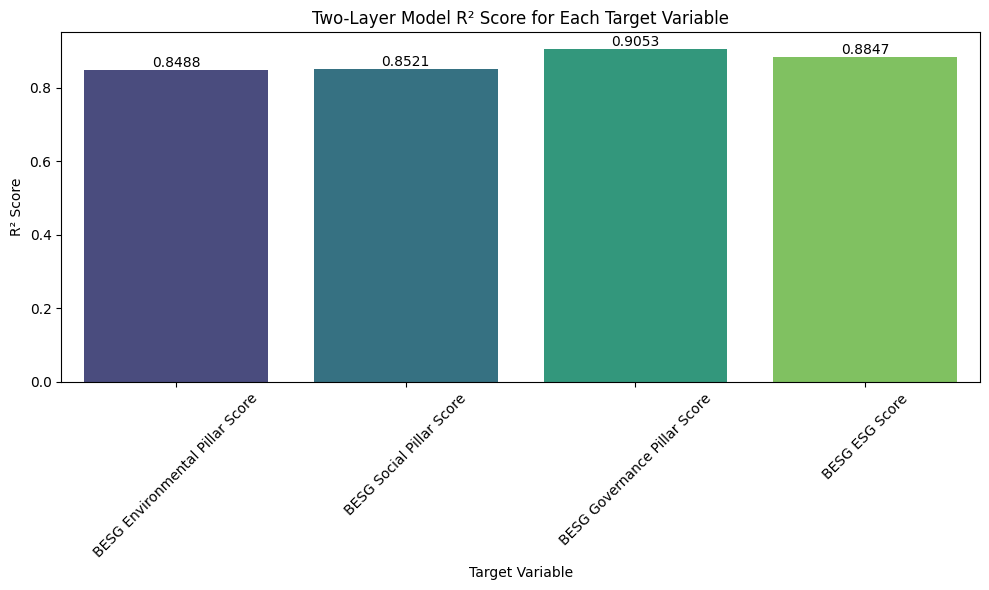

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_32496/4210039086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')


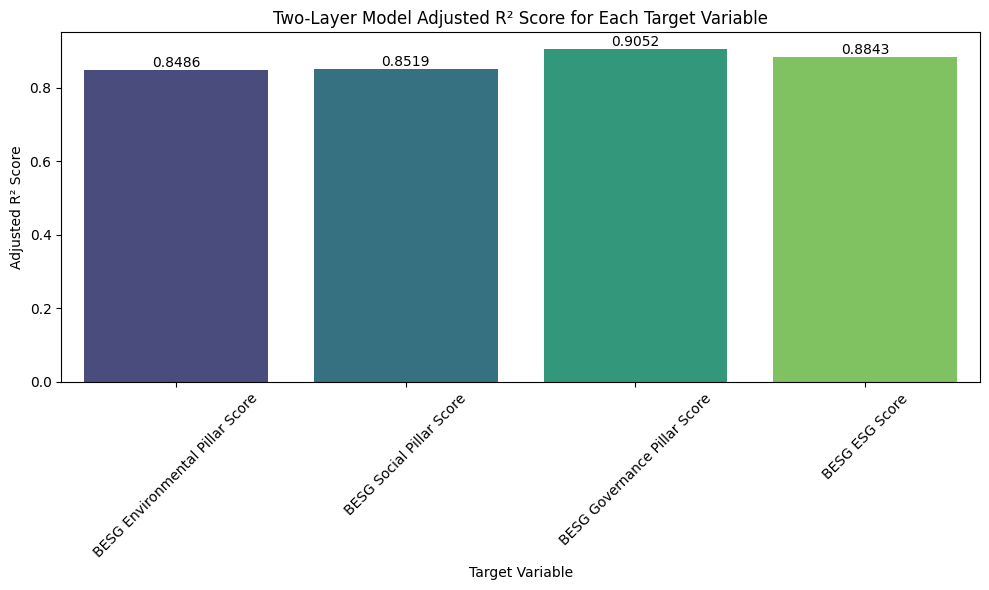

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_32496/4210039086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')


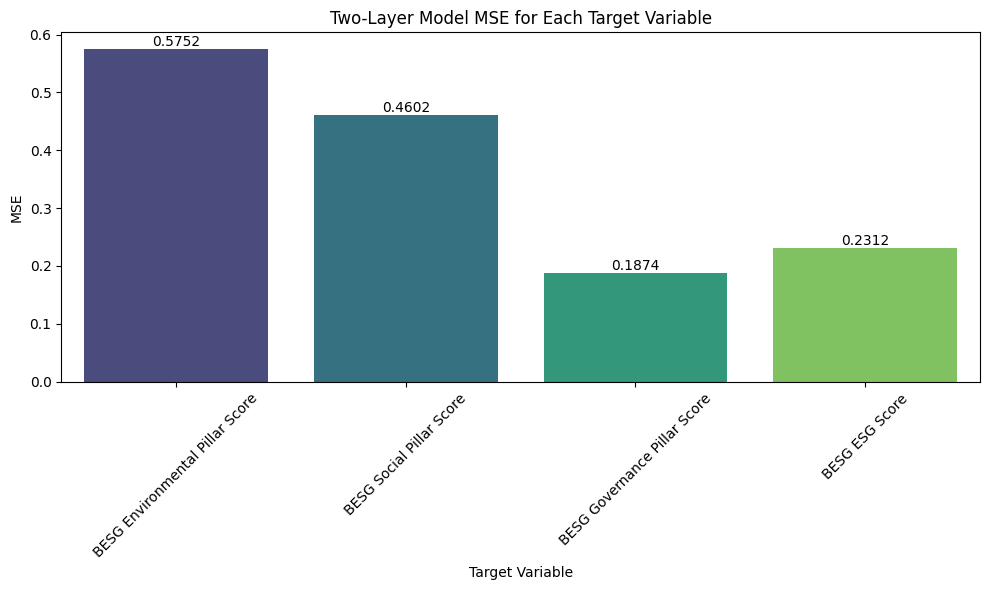

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_32496/4210039086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')


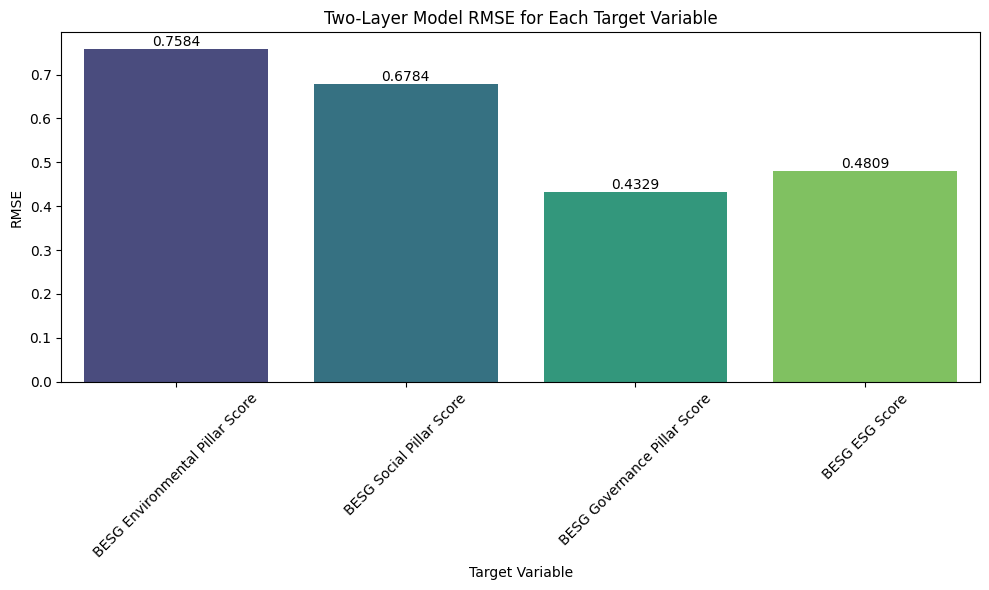

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_32496/4210039086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')


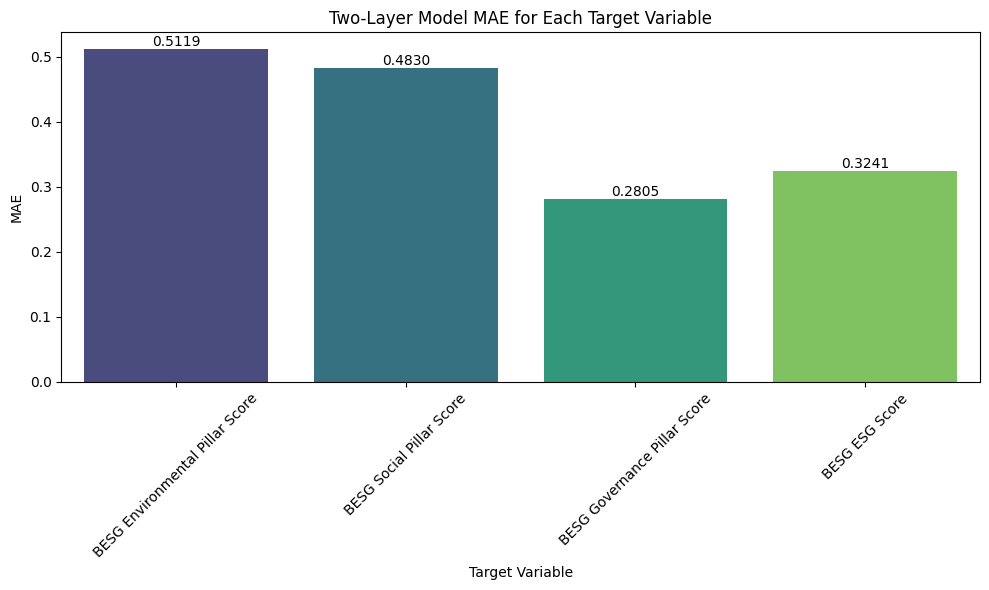

In [13]:
# Plot performance metrics for each target variable
for metric in ['R² Score', 'Adjusted R² Score', 'MSE', 'RMSE', 'MAE']:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=two_layer_metrics['Target'], y=two_layer_metrics[metric], palette='viridis')
    plt.title(f'Two-Layer Model {metric} for Each Target Variable')
    plt.xlabel('Target Variable')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    # Annotate each bar with its value
    for index, value in enumerate(two_layer_metrics[metric]):
        plt.text(index, value, f'{value:.4f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

/Users/james/Documents/Documents - Zhi’s MacBook Air/GitHub/esg_analytics/TwoLayerModel/TwoLayerModel.py:518: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
/Users/james/Documents/Documents - Zhi’s MacBook Air/GitHub/esg_analytics/TwoLayerModel/TwoLayerModel.py:518: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
/Users/james/Documents/Documents - Zhi’s MacBook Air/GitHub/esg_analytics/TwoLayerModel/TwoLayerModel.py:518: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


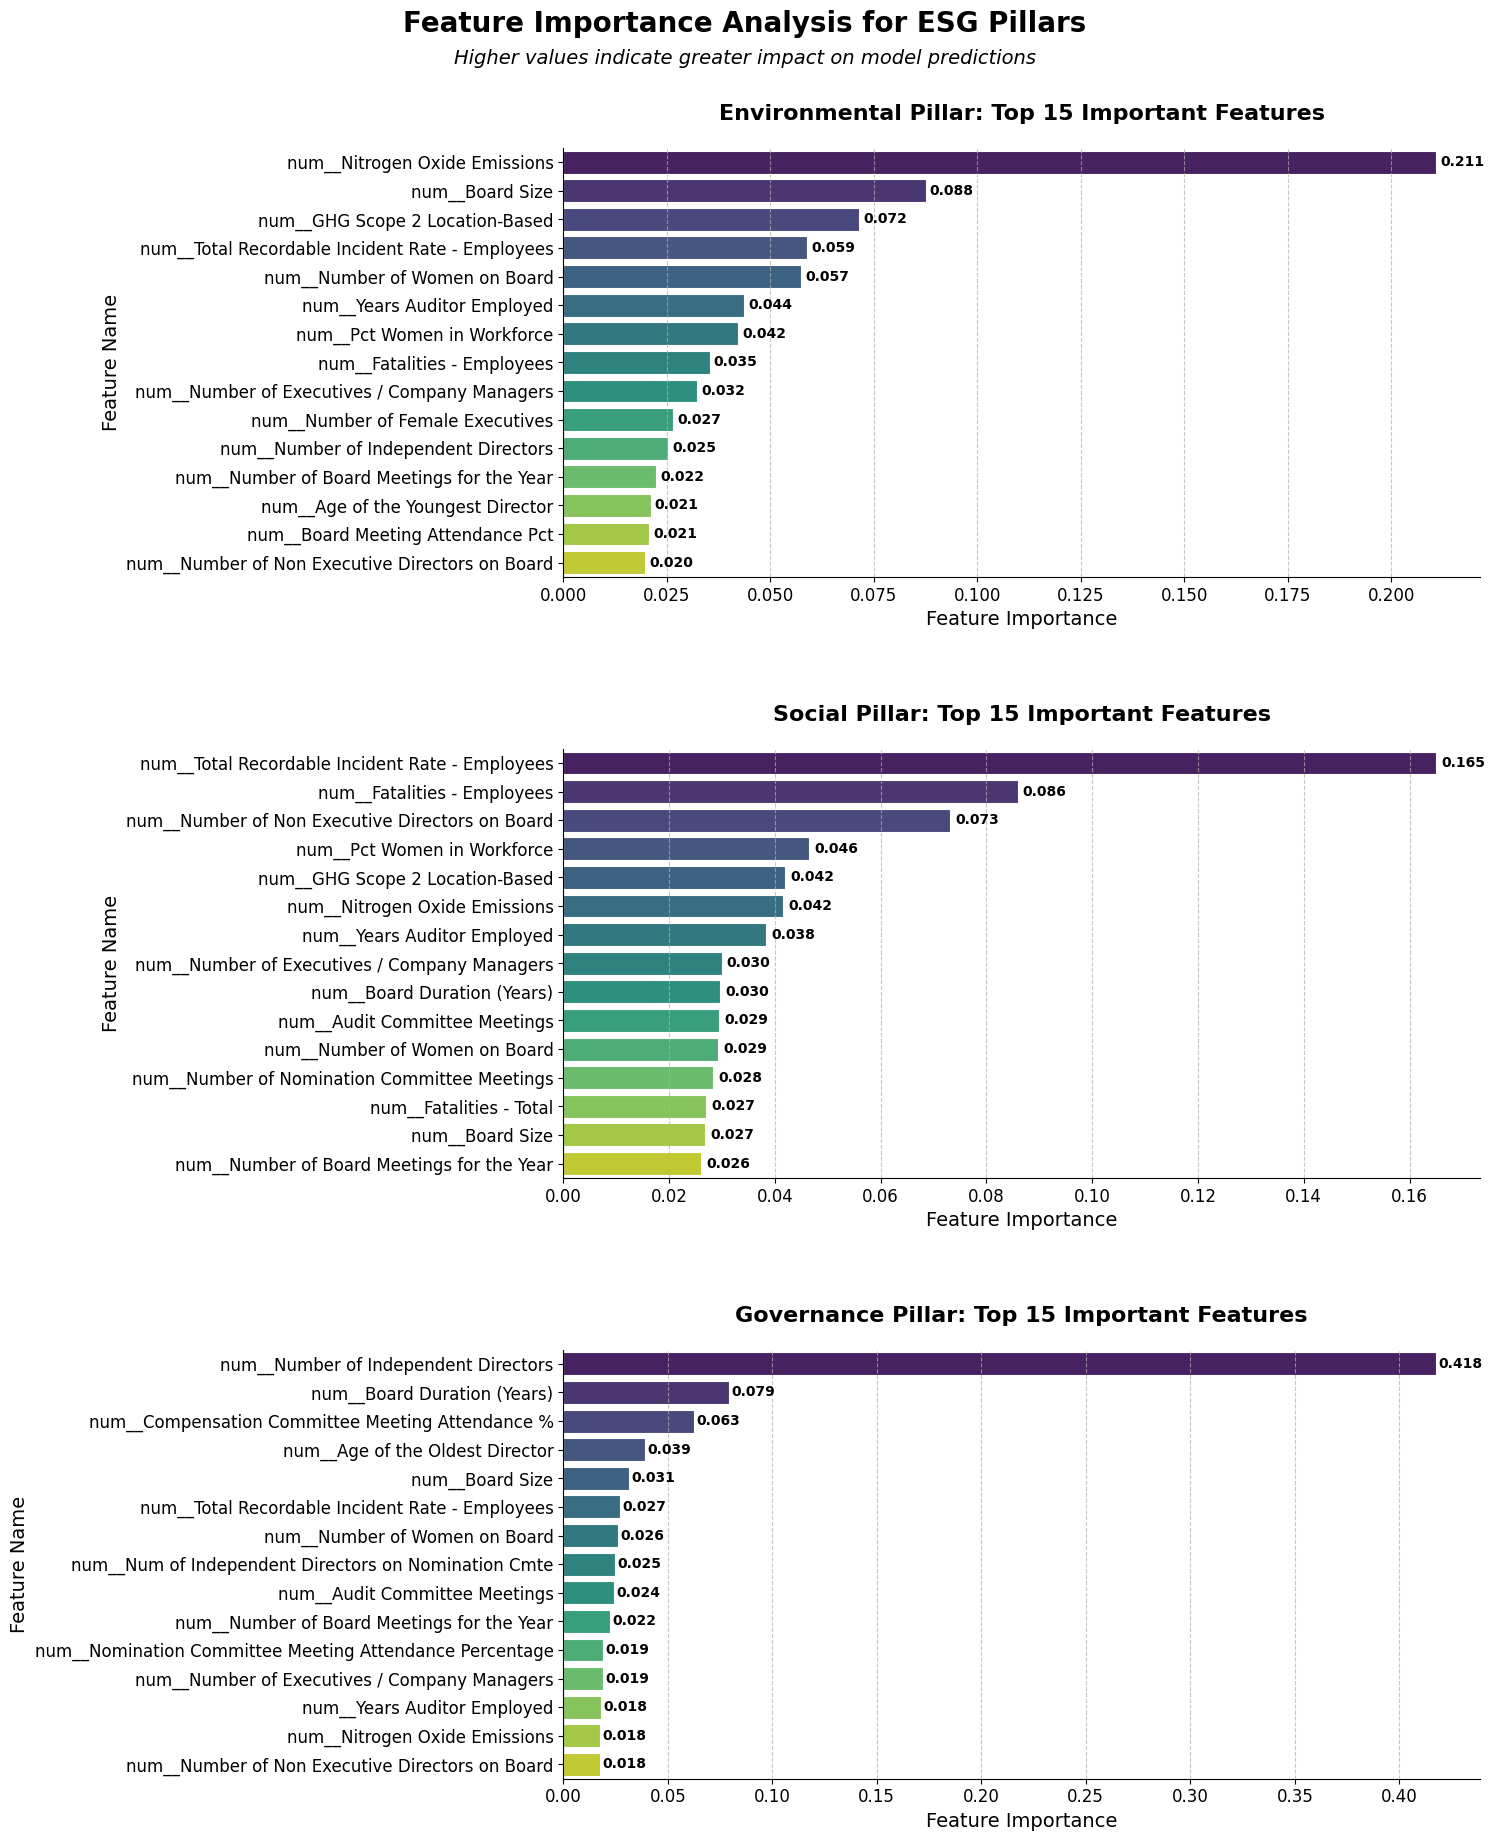

In [14]:
plot_feature_importances(two_layer_model, top_n=15)

In [15]:
# Analyze the coefficients of the Layer 2 Linear Regression model
layer2_coefficients = pd.DataFrame({
    'Pillar/Disclosure Score': pillar_disclosure_columns,
    # extract coefficients from OLS model
    'Coefficient': two_layer_model.layer2_coefficients
})

print("\nLayer 2 Model Coefficients:")
print(layer2_coefficients)


Layer 2 Model Coefficients:
           Pillar/Disclosure Score  Coefficient
0  BESG Environmental Pillar Score     0.544469
1         BESG Social Pillar Score     0.325550
2     BESG Governance Pillar Score     0.182676


In [16]:
# Compare Layer 2 coefficients to a simple linear regression model

X = df[pillar_disclosure_columns]
y = df[final_target]

lr_model = sm.OLS(y, X).fit()
print("\nLinear Regression Model Summary:")
lr_summary = lr_model.summary()

print("\nComparison of Layer 2 Model Coefficients and Linear Regression Coefficients:")

comparison_df = pd.DataFrame({
    'Layer 2': two_layer_model.layer2_coefficients,
    'Linear Regression': lr_model.params
}, index=pillar_disclosure_columns)

comparison_df = comparison_df.sort_values(by='Layer 2', ascending=False)
print(comparison_df)


Linear Regression Model Summary:

Comparison of Layer 2 Model Coefficients and Linear Regression Coefficients:
                                  Layer 2  Linear Regression
BESG Environmental Pillar Score  0.544469           0.483350
BESG Social Pillar Score         0.325550           0.290668
BESG Governance Pillar Score     0.182676           0.231662


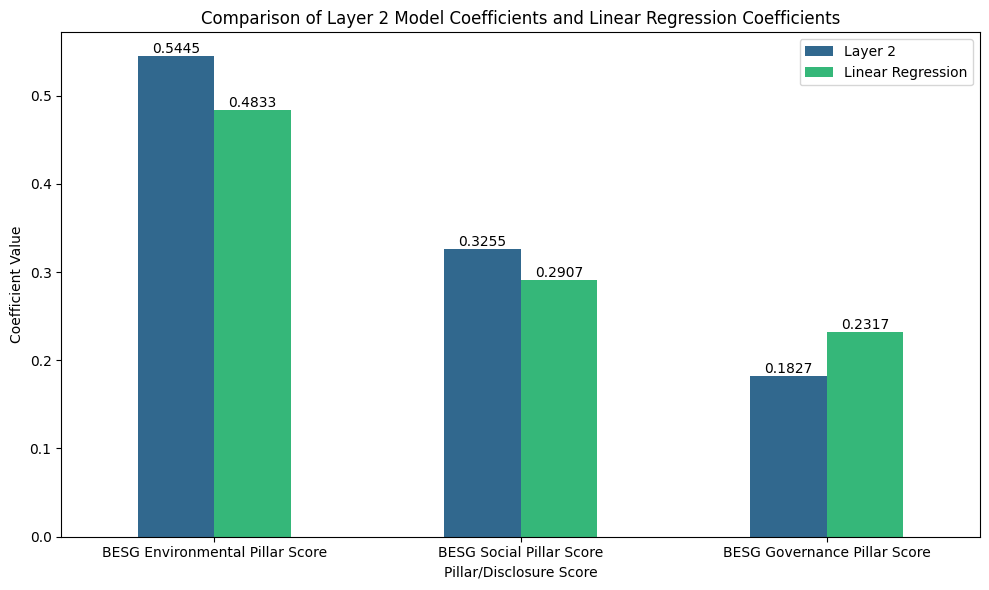

In [17]:
# Plot differences in coefficients
plt.figure(figsize=(10, 6))
color = sns.color_palette("viridis", 2)
comparison_df.plot(kind='bar', color=color, ax=plt.gca())
plt.title('Comparison of Layer 2 Model Coefficients and Linear Regression Coefficients')
plt.ylabel('Coefficient Value')
# Label the bars with their values
for index, value in enumerate(comparison_df['Layer 2']):
    plt.text(index - 0.125, value, f'{value:.4f}', ha='center', va='bottom')
for index, value in enumerate(comparison_df['Linear Regression']):
    plt.text(index + 0.125, value, f'{value:.4f}', ha='center', va='bottom')
plt.xlabel('Pillar/Disclosure Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/var/folders/08/xxsq81ks0gx_hgrmn3w7_0p00000gn/T/ipykernel_32496/4241095067.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Pillar/Disclosure Score', data=layer2_coefficients, palette='coolwarm')


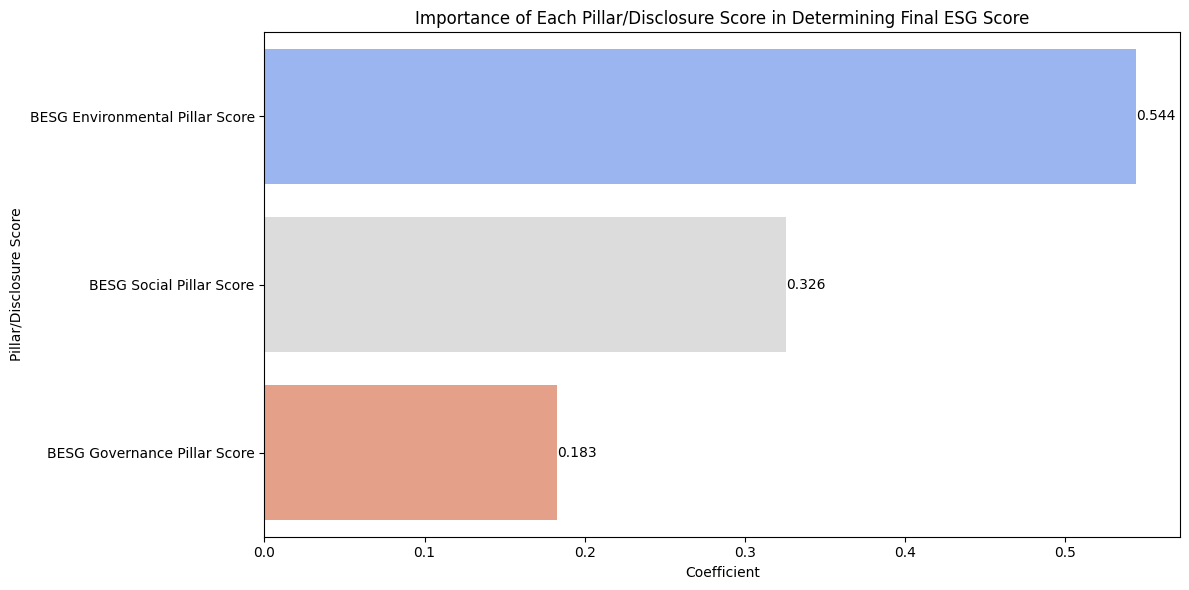

In [18]:
# Plot coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Pillar/Disclosure Score', data=layer2_coefficients, palette='coolwarm')
plt.title('Importance of Each Pillar/Disclosure Score in Determining Final ESG Score')
plt.xlabel('Coefficient')
plt.ylabel('Pillar/Disclosure Score')
# Label each bar
for i in range(len(layer2_coefficients)):
    plt.text(x=layer2_coefficients['Coefficient'].iloc[i], y=i,
             s=f"{layer2_coefficients['Coefficient'].iloc[i]:.3f}",
             va='center')
plt.tight_layout()
plt.show()

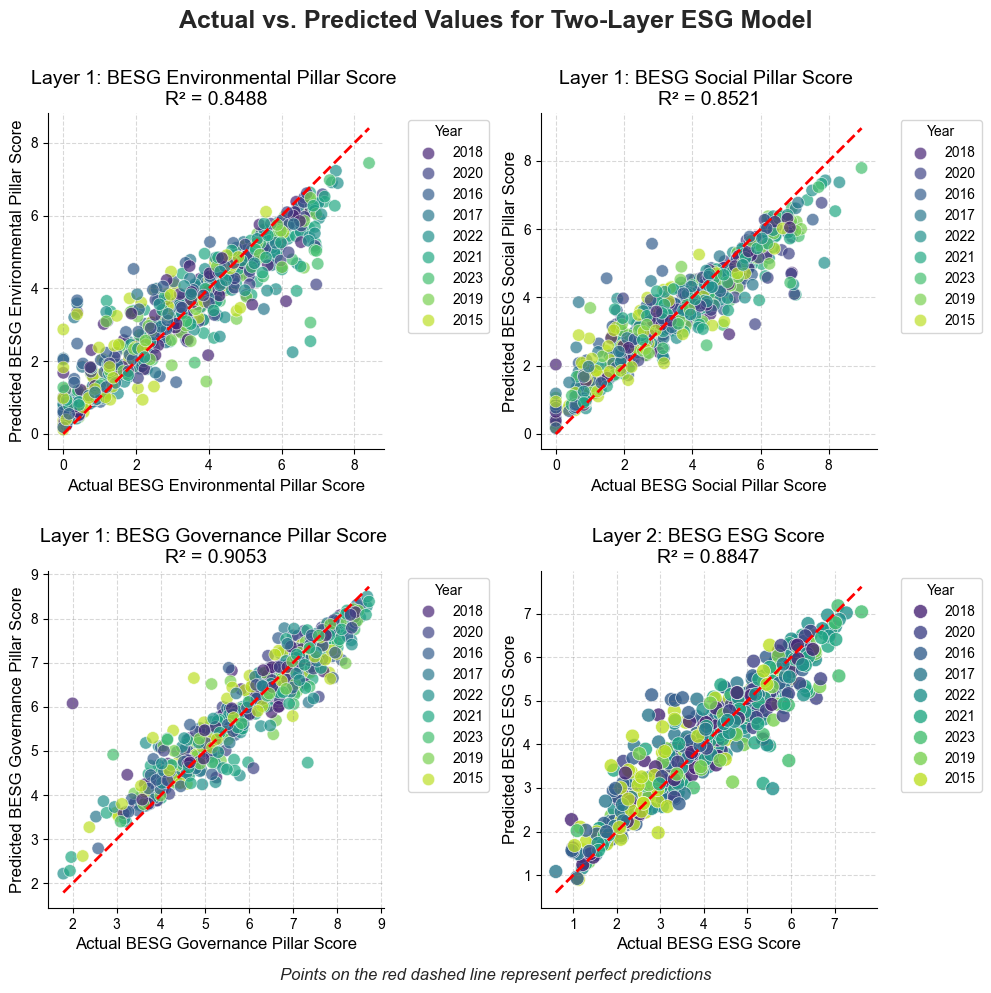

In [19]:
plot_actual_vs_predicted_two_layer(two_layer_model, X_combined, y_combined)

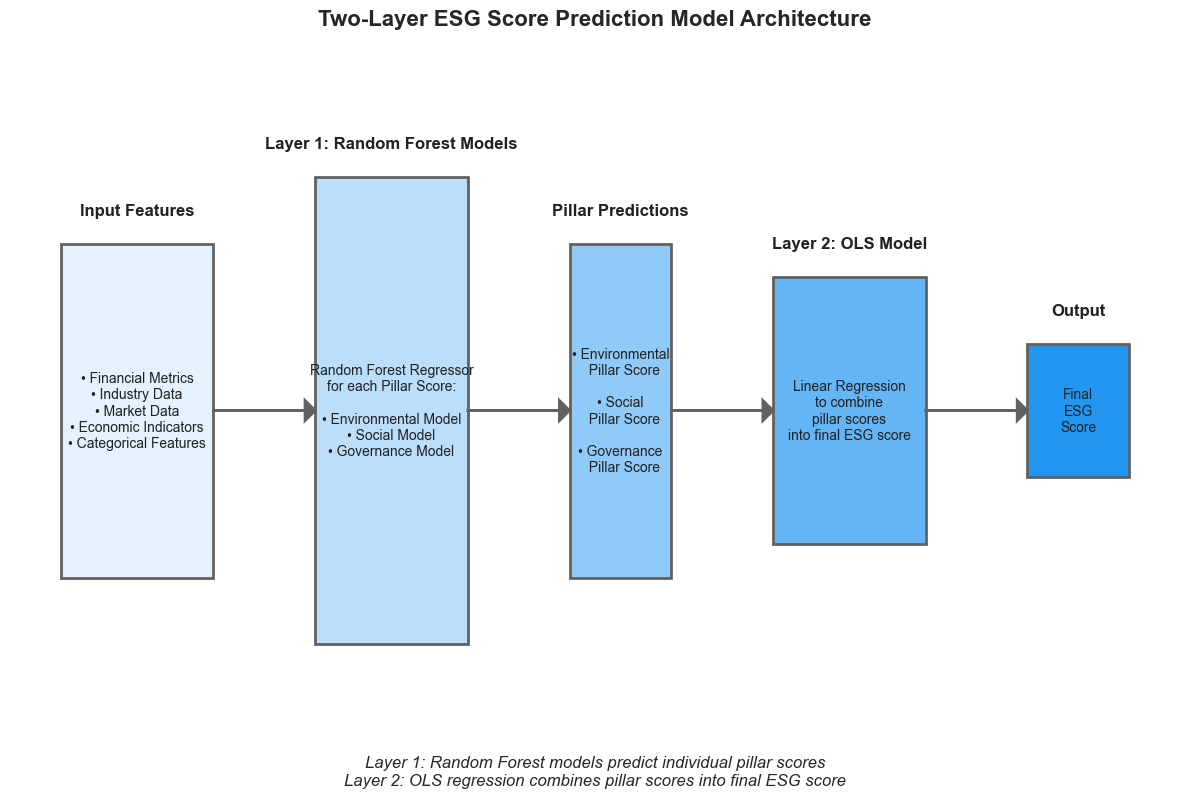

In [20]:
import matplotlib.patches as patches

def plot_two_layer_model_diagram():
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Define colors
    input_color = "#E3F2FD"  # Light blue
    layer1_color = "#BBDEFB"  # Medium blue
    pillar_color = "#90CAF9"  # Blue
    layer2_color = "#64B5F6"  # Darker blue
    output_color = "#2196F3"  # Darkest blue
    arrow_color = "#616161"  # Gray
    text_color = "#212121"  # Dark gray

    # Coordinates and dimensions
    input_x, input_y = 1, 6
    input_width, input_height = 3, 5

    layer1_x, layer1_y = 6, 5
    layer1_width, layer1_height = 3, 7

    pillar_x, pillar_y = 11, 6
    pillar_width, pillar_height = 2, 5

    layer2_x, layer2_y = 15, 6.5
    layer2_width, layer2_height = 3, 4

    output_x, output_y = 20, 7.5
    output_width, output_height = 2, 2

    # Draw input features box
    input_rect = patches.Rectangle((input_x, input_y), input_width, input_height,
                                  linewidth=2, edgecolor=arrow_color, facecolor=input_color)
    ax.add_patch(input_rect)

    # Draw Layer 1 box (Random Forest Models)
    layer1_rect = patches.Rectangle((layer1_x, layer1_y), layer1_width, layer1_height,
                                   linewidth=2, edgecolor=arrow_color, facecolor=layer1_color)
    ax.add_patch(layer1_rect)

    # Draw Pillar Scores box
    pillar_rect = patches.Rectangle((pillar_x, pillar_y), pillar_width, pillar_height,
                                   linewidth=2, edgecolor=arrow_color, facecolor=pillar_color)
    ax.add_patch(pillar_rect)

    # Draw Layer 2 box (OLS Regression)
    layer2_rect = patches.Rectangle((layer2_x, layer2_y), layer2_width, layer2_height,
                                   linewidth=2, edgecolor=arrow_color, facecolor=layer2_color)
    ax.add_patch(layer2_rect)

    # Draw output box (Final ESG Score)
    output_rect = patches.Rectangle((output_x, output_y), output_width, output_height,
                                   linewidth=2, edgecolor=arrow_color, facecolor=output_color)
    ax.add_patch(output_rect)

    # Draw arrows
    # Input to Layer 1
    ax.arrow(input_x + input_width, input_y + input_height/2,
             layer1_x - input_x - input_width - 0.2, 0,
             head_width=0.3, head_length=0.2, fc=arrow_color, ec=arrow_color, linewidth=2)

    # Layer 1 to Pillar Scores
    ax.arrow(layer1_x + layer1_width, layer1_y + layer1_height/2,
             pillar_x - layer1_x - layer1_width - 0.2, 0,
             head_width=0.3, head_length=0.2, fc=arrow_color, ec=arrow_color, linewidth=2)

    # Pillar Scores to Layer 2
    ax.arrow(pillar_x + pillar_width, pillar_y + pillar_height/2,
             layer2_x - pillar_x - pillar_width - 0.2, 0,
             head_width=0.3, head_length=0.2, fc=arrow_color, ec=arrow_color, linewidth=2)

    # Layer 2 to Output
    ax.arrow(layer2_x + layer2_width, layer2_y + layer2_height/2,
             output_x - layer2_x - layer2_width - 0.2, 0,
             head_width=0.3, head_length=0.2, fc=arrow_color, ec=arrow_color, linewidth=2)

    # Add labels
    ax.text(input_x + input_width/2, input_y + input_height + 0.5, 'Input Features',
            ha='center', va='center', fontsize=12, fontweight='bold', color=text_color)

    feature_text = "• Financial Metrics\n• Industry Data\n• Market Data\n• Economic Indicators\n• Categorical Features"
    ax.text(input_x + input_width/2, input_y + input_height/2, feature_text,
            ha='center', va='center', fontsize=10, color=text_color)

    ax.text(layer1_x + layer1_width/2, layer1_y + layer1_height + 0.5, 'Layer 1: Random Forest Models',
            ha='center', va='center', fontsize=12, fontweight='bold', color=text_color)

    rf_text = "Random Forest Regressor\nfor each Pillar Score:\n\n• Environmental Model\n• Social Model\n• Governance Model"
    ax.text(layer1_x + layer1_width/2, layer1_y + layer1_height/2, rf_text,
            ha='center', va='center', fontsize=10, color=text_color)

    ax.text(pillar_x + pillar_width/2, pillar_y + pillar_height + 0.5, 'Pillar Predictions',
            ha='center', va='center', fontsize=12, fontweight='bold', color=text_color)

    pillar_text = "• Environmental\n  Pillar Score\n\n• Social\n  Pillar Score\n\n• Governance\n  Pillar Score"
    ax.text(pillar_x + pillar_width/2, pillar_y + pillar_height/2, pillar_text,
            ha='center', va='center', fontsize=10, color=text_color)

    ax.text(layer2_x + layer2_width/2, layer2_y + layer2_height + 0.5, 'Layer 2: OLS Model',
            ha='center', va='center', fontsize=12, fontweight='bold', color=text_color)

    ols_text = "Linear Regression\nto combine\npillar scores\ninto final ESG score"
    ax.text(layer2_x + layer2_width/2, layer2_y + layer2_height/2, ols_text,
            ha='center', va='center', fontsize=10, color=text_color)

    ax.text(output_x + output_width/2, output_y + output_height + 0.5, 'Output',
            ha='center', va='center', fontsize=12, fontweight='bold', color=text_color)

    output_text = "Final\nESG\nScore"
    ax.text(output_x + output_width/2, output_y + output_height/2, output_text,
            ha='center', va='center', fontsize=10, color=text_color)

    # Set axis limits and remove ticks
    ax.set_xlim(0, 23)
    ax.set_ylim(3, 14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Add title
    plt.suptitle('Two-Layer ESG Score Prediction Model Architecture', fontsize=16, fontweight='bold', y=0.98)
    plt.figtext(0.5, 0.01,
                'Layer 1: Random Forest models predict individual pillar scores\nLayer 2: OLS regression combines pillar scores into final ESG score',
                ha='center', fontsize=12, fontstyle='italic')

    plt.tight_layout()
    plt.show()

# Plot the model architecture diagram
plot_two_layer_model_diagram()

### 3. Train a single-layer model for additional comparison

In [23]:
# Define the preprocessing steps for baseline
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Create and train the baseline model
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))
])

# Fit on training data (only predicting final ESG score)
baseline_model.fit(X_train, y_train[final_target])

# Make predictions
baseline_predictions = baseline_model.predict(X_test)

# Calculate metrics
baseline_mse = mean_squared_error(y_test[final_target], baseline_predictions)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test[final_target], baseline_predictions)
baseline_r2 = r2_score(y_test[final_target], baseline_predictions)
baseline_adjusted_r2 = 1 - (1 - baseline_r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

# Get two-tier model predictions
two_layer_prediction = two_layer_metrics[two_layer_metrics['Target'] == final_target]

# Create a comparison DataFrame
comparison = pd.DataFrame({
    'Model': ['Baseline (Single-Layer)', 'Two-Layer'],
    'MSE': [baseline_mse, two_layer_prediction['MSE'].values[0]],
    'RMSE': [baseline_rmse, two_layer_prediction['RMSE'].values[0]],
    'MAE': [baseline_mae, two_layer_prediction['MAE'].values[0]],
    'R-squared': [baseline_r2, two_layer_prediction['R² Score'].values[0]],
    'Adjusted R-squared': [baseline_adjusted_r2, two_layer_prediction['Adjusted R² Score'].values[0]]
})

print("\nComparison between Baseline and Two-Tier models for ESG Score prediction:")
print(comparison)


Comparison between Baseline and Two-Tier models for ESG Score prediction:
                     Model       MSE      RMSE       MAE  R-squared  \
0  Baseline (Single-Layer)  0.631904  0.794924  0.614773   0.722062   
1                Two-Layer  0.231242  0.480877  0.324057   0.884673   

   Adjusted R-squared  
0            0.649467  
1            0.884264  


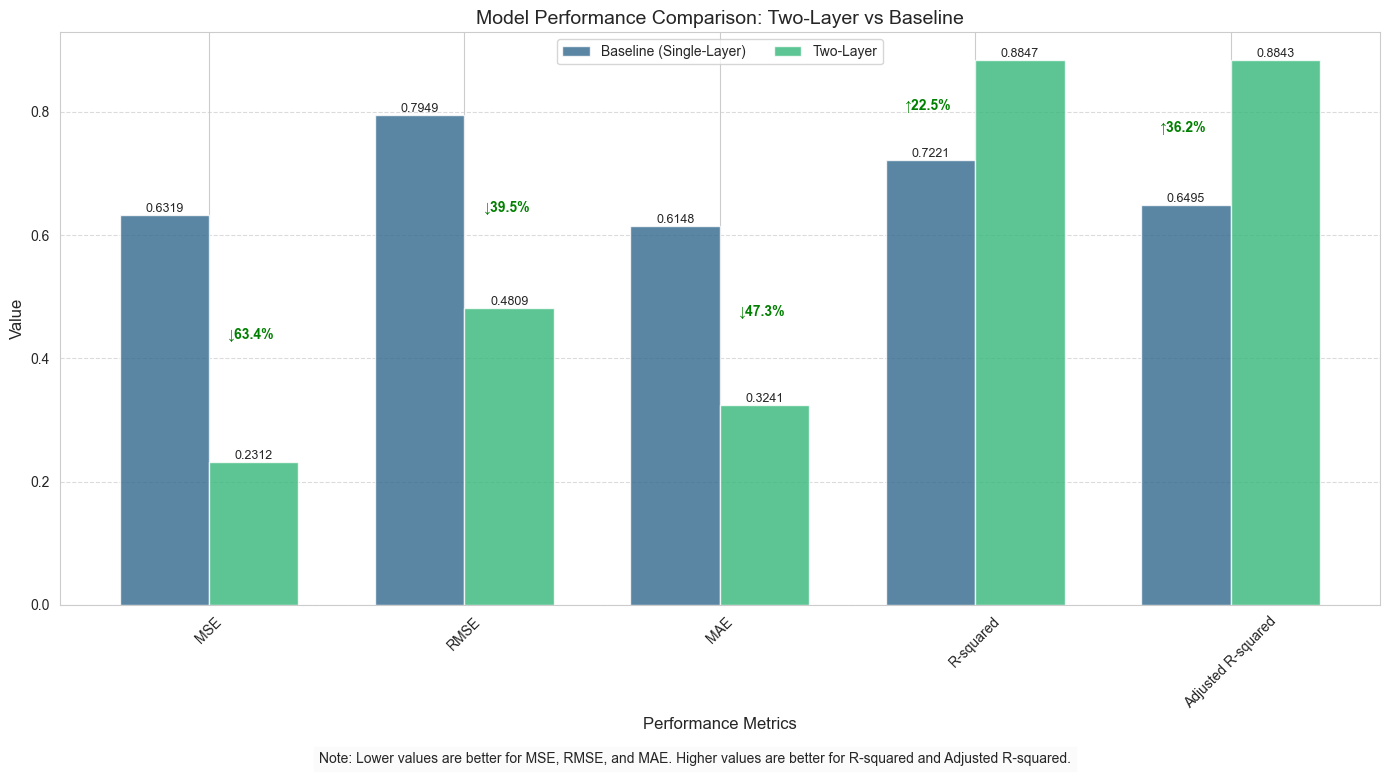

In [33]:
# Set up colors for better visual distinction
colors = sns.color_palette("viridis", len(comparison['Model']))

# Create figure
plt.figure(figsize=(14, 8))

# Set width of bars
bar_width = 0.35
index = np.arange(len(comparison.columns[1:]))  # Skip the 'Model' column

# Create grouped bars
for i, model in enumerate(comparison['Model']):
    # Plot the metrics for this model
    bars = plt.bar(index + i*bar_width, comparison.iloc[i, 1:], 
                 bar_width, label=model, color=colors[i], alpha=0.8)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Add labels and title
plt.xlabel('Performance Metrics', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Model Performance Comparison: Two-Layer vs Baseline', fontsize=14)
plt.xticks(index + bar_width/2, comparison.columns[1:], rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), ncol=2)

# Add a note about interpretation
plt.figtext(0.5, 0.01, 
           "Note: Lower values are better for MSE, RMSE, and MAE. Higher values are better for R-squared and Adjusted R-squared.", 
           ha='center', fontsize=10, bbox=dict(facecolor='#f8f9fa', alpha=0.5))

# Add percentage improvement for each metric
for i, metric in enumerate(comparison.columns[1:]):
    if metric in ['MSE', 'RMSE', 'MAE']:  # Lower is better
        gain = (comparison[metric].iloc[0] - comparison[metric].iloc[1]) / comparison[metric].iloc[0] * 100
        plt.text(i + 0.25, (comparison[metric].iloc[0] + comparison[metric].iloc[1])/2, 
                f"↓{gain:.1f}%", color='green', fontweight='bold')
    else:  # Higher is better
        gain = (comparison[metric].iloc[1] - comparison[metric].iloc[0]) / comparison[metric].iloc[0] * 100
        plt.text(i - 0.1, (comparison[metric].iloc[0] + comparison[metric].iloc[1])/2, 
                f"↑{gain:.1f}%", color='green', fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()